<a href="https://colab.research.google.com/github/Ragnarok540/sympy-tutorial/blob/main/kapitza_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.youtube.com/watch?v=oeneVhFh4-o

import sympy as smp
import sympy.physics.mechanics as smp_mech
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

In [ ]:
smp_mech.init_vprinting()

m, g, ell, a, w, b, t = smp.symbols('m g ell a w b t')

theta = smp_mech.dynamicsymbols('theta')

x = ell * smp.sin(theta)
y = ell * smp.cos(theta) + a * smp.sin(w * t)

theta_dot = smp.diff(theta, t)
theta_ddot = smp.diff(theta_dot, t)
x_dot = smp.diff(x, t)
y_dot = smp.diff(y, t)

T = smp.Rational(1, 2) * m * (x_dot**2 + y_dot**2)
V = m * g * y
L = T - V

damping = True

if damping:
    eqn_1 = smp.diff(smp.diff(L, theta_dot), t) - smp.diff(L, theta) + b * theta_dot
else:
    eqn_1 = smp.diff(smp.diff(L, theta_dot), t) - smp.diff(L, theta)

sln = smp.solve(eqn_1, theta_ddot)[0]

f = smp.Matrix([theta_dot, sln])
f = smp.simplify(f)
q = smp.Matrix([theta, theta_dot])
q_dot = smp.diff(q, t)

smp.Eq(q_dot, f)

      ⎡                    θ̇                    ⎤
      ⎢                                         ⎥
⎡θ̇⎤   ⎢             ⎛     2             ⎞       ⎥
⎢ ⎥ = ⎢-b⋅θ̇ + ell⋅m⋅⎝- a⋅w ⋅sin(t⋅w) + g⎠⋅sin(θ)⎥
⎣θ̈⎦   ⎢─────────────────────────────────────────⎥
      ⎢                    2                    ⎥
      ⎣                 ell ⋅m                  ⎦

In [ ]:
if damping:
    f1 = f[1].subs([(g, 9.81), (ell, 1.0), (m, 1.0), (a, 0.1), (w, 2.0 * smp.pi * 40.0), (b, 3.0)])
else:
    f1 = f[1].subs([(g, 9.81), (ell, 1.0), (m, 1.0), (a, 0.1), (w, 2.0 * smp.pi * 40.0)])

f1_fun = smp.lambdify([theta, theta_dot, t], f1)
f1

    ⎛         2                   ⎞               
1.0⋅⎝- 640.0⋅π ⋅sin(80⋅π⋅t) + 9.81⎠⋅sin(θ) - 3.0⋅θ̇

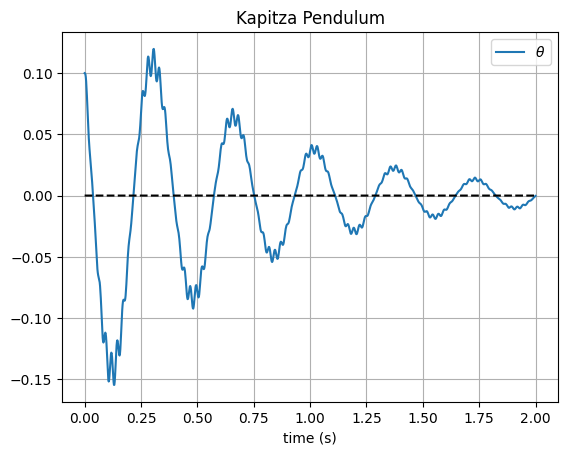

In [ ]:
def kapitza_ODE(t, y):
    theta_ = y[0]
    theta_dot_ = y[1]

    return (
        theta_dot_,
        f1_fun(theta_, theta_dot_, t)
    )

tfinal = 2
slowdown_factor = 20
frame_rate = 30 * slowdown_factor
x0 = [0.1, 0]

sol = solve_ivp(kapitza_ODE, [0, tfinal], x0, t_eval=np.linspace(0, tfinal, tfinal * frame_rate + 1))

theta = sol.y[0]
t = sol.t

plt.plot(t, theta, label="$\\theta$")
plt.legend()
plt.grid()
plt.xlabel("time (s)")
plt.title('Kapitza Pendulum')
plt.plot(t, np.zeros_like(t), 'k--')
plt.show()

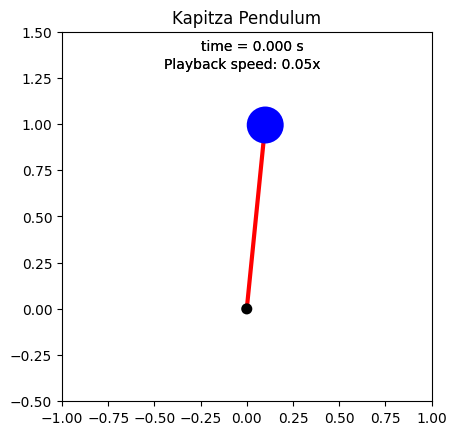

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-1, 1)
ax.set_ylim(-0.5, 1.5)
ax.set_title('Kapitza Pendulum')

m = 1
g = 9.81
ell = 1
a = 0.1
w = 2 * np.pi * 40
b = 3

circle = ax.add_patch(plt.Circle((0, 0), 0.1, fc='b', zorder=3))
stick = ax.add_line(Line2D([0, 1], [0, 1], color='r', linewidth=3))
pivot = ax.add_patch(plt.Circle((0, 0), 0.03, fc='k', zorder=3))
timestamp = ax.add_artist(plt.text(-0.25, 1.4, 'time = 0.00 s'))
ax.add_artist(plt.text(-0.45, 1.3, 'Playback speed: 0.05x'))

def animate(i):
    px = ell * np.sin(theta[i])
    py = ell * np.cos(theta[i]) + a * np.sin(w * t[i])
    circle.set_center((px, py))
    pivot.set_center((0, a * np.sin(w * t[i])))
    stick.set_data([0, px], [a * np.sin(w * t[i]), py])
    timestamp.set(text=f'time = {t[i]:.3f} s')

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=30)
ani.save('kapitza_pendulum.gif', writer=ffmpeg_writer)